In [27]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.contrib import appsi

In [28]:
class BES_MILP_model(): 
    def __init__(self, name, E_min=0., E_max=20_000.*3600, P_max_cha=20_000., P_max_dis=20_000., eta_cha=0.95, eta_dis=0.95):
        '''
        A battery energy storag model with charging and discharging efficiencies.
        The model needs to be used in an parent model to function correctly!
        The parent pyomo model is required to have the following attributes:
        - model.timepoints : pyo.RangeSet, timepoints of the simulation
        - model.periods : pyo.RangeSet, eriods of the simulation
        - model.delta_t : pyo.Param, timedelta of the simulation
        
        Parameter:
        ---------
        E_min : float, minimum energy of the storage in J
        E_max : float, maximum energy of the storage in J
        P_max_cha : maximum charging power in W
        P_max_dis : maximum discharging powre in W
        eta_cha : float [0, 1] charging efficiency (no unit)
        eta_dis : float [0, 1] discharging efficiency (no unit)'''

        # Parameters
        self.name      = name
        self.E_min     = E_min # J
        self.E_max     = E_max # 20 kWh in J
        self.P_max_cha = P_max_cha # W
        self.P_max_dis = P_max_dis # W
        self.eta_cha   = eta_cha # 1
        self.eta_dis   = eta_dis # 1

        # config info
        self.state_inputs     = ['E_BES_0'] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.forecast_inputs  = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.controll_outputs = ['P_el'] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = ['P_el'] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods

    def pyo_block_rule(self, block):
        
        model = block.model()

        block.E_BES_0   = pyo.Param(mutable=True, domain=pyo.NonNegativeReals, validate=lambda _, E: self.E_min <= E and E <= self.E_max) # J

        # Variables
        block.E         = pyo.Var(model.timepoints, domain=pyo.NonNegativeReals, bounds=(self.E_min, self.E_max)) # J
        block.P_el      = pyo.Var(model.periods, domain=pyo.Reals) # Electrical Power in W (feed in = positive, consumption = negative)

        # helper Variables
        block.P_el_cha  = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Electrical charging Power in W (helper)
        block.P_el_dis  = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Electrical discharging Power in W (helper)
        block.bool      = pyo.Var(model.periods, domain=pyo.Boolean) # prevent same time charging and discharging

        @block.Constraint(model.periods)
        def energy_balance(block, p):
            return block.E[p+1] == block.E[p] + (block.P_el_cha[p] * self.eta_cha - block.P_el_dis[p] / self.eta_dis) * model.delta_t
        
        @block.Constraint(model.periods)
        def output_power(block, p):
            return block.P_el[p] == block.P_el_cha[p] - block.P_el_dis[p]

        @block.Constraint(model.periods)
        def power_limit_bool_cha(block, p):
            return block.P_el_cha[p] <= block.bool[p] * self.P_max_cha
        
        @block.Constraint(model.periods)
        def power_limit_bool_dis(block, p):
            return block.P_el_dis[p] <= block.bool[p] * self.P_max_dis

        @block.Constraint()
        def initial_condition(block):
            return block.E[0] == block.E_BES_0

In [29]:
class EC__Residual_Load_MILP_model(): 
    def __init__(self, name='EC'):
        '''
        An Energy Community MILP Model.
        The parent pyomo model is required to have the following attributes:
        - model.timepoints : pyo.RangeSet, timepoints of the simulation
        - model.periods : pyo.RangeSet, eriods of the simulation
        - model.delta_t : pyo.Param, timedelta of the simulation
        
        Parameter:
        ---------
        name : str, name of the Energy Community model'''

        # Parameters
        self.name      = name

        # config info
        self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.forecast_inputs  = ['P_resid_ec'] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.controll_outputs = [] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = ['P_el'] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods

    def pyo_block_rule(self, block):
        model = block.model()
        block.P_el       = pyo.Var(model.periods, domain=pyo.Reals) # Electrical Power in W (feed in = positive, consumption = negative)
        block.P_resid_ec = pyo.Param(model.periods, mutable=True, domain=pyo.Reals) # Residual load of EC (surplus_load > 0 > surplus_generation)

        # EC / Grid constraints:
        @block.Constraint(model.periods)
        def grid_constraint(b, p):
            return (b.P_el[p] == b.P_resid_ec[p]) 

In [126]:
class MPController():
    def __init__(self, n_periods, delta_t, pyo_solver_name='appsi_highs'):
        '''A model predicteve Controller utilizing MILP with pyomo. 
        MILP Models can be added to the model via the add_model() method. Added modles need to follow a given structure. 
        Please find examples for reference.
        Inputs and outputs get configured automatically based on the added models.
        
        Parameters
        ----------
        n_periods : int, length of optimization horizon
        delta_t : int, timedelta of the controller in s
        pyo_solver_name : str, name of a pyomo solver (passed to pyo.SolverFactory)
        '''
        self.n_periods  = n_periods
        self.delta_t    = delta_t
        self.inputs = []
        self.outputs = []

        self.solver = pyo.SolverFactory(pyo_solver_name)

        # make Energy Community model
        self.model      = pyo.ConcreteModel()

        self.model.timepoints = pyo.RangeSet(0, n_periods) # Range of timepoints
        self.model.periods    = pyo.RangeSet(0, n_periods-1) # Range of periods
        self.model.delta_t    = pyo.Param(initialize=60*15) # s

        self.model.P_resid_plus  = pyo.Var(self.model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W 
        self.model.P_resid_minus = pyo.Var(self.model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W

        self.components = [] # list of components that get added via add_model (they need to follow a specific syntax! see examples)

        # Grid constraints:
        @self.model.Constraint(self.model.periods)
        def grid_constraint(m, p):
            return (sum([m.find_component(comp.name).P_el[p] for comp in self.components if 'P_el' in comp.shares]) 
                    + m.P_resid_plus[p] - m.P_resid_minus[p] == 0) # 

        # TODO: this could be made parametric / object oriented
        @self.model.Objective(sense=pyo.minimize)
        def objective_rule(m):
            return pyo.quicksum(m.P_resid_plus[p]+m.P_resid_minus[p] for p in m.periods)
        
        self.forcasters = [] # list of forcasters that get added via add_model (they need to follow a specific syntax! see examples)    

    def add_model(self, component):
        '''add a model which needs to follow the given structure, see the examples'''
        # add components to the list of components
        self.components += [component]
        # Add constraints as a block to the EC model:
        self.model.__setattr__(component.name, pyo.Block(rule=component.pyo_block_rule))
        # append model inputs
        self.inputs += [si+'_of_'+component.name for si in component.state_inputs]

    def add_forcaster(self, forcaster, for_model, for_var):
        '''Adds a forcasting objct to the controller for a model input of the MILP model
        Parameters
        ----------
        forcaster :  Forcast, forcsting object for a variable 
        for_model : MILP_Model, the model that the forcast is for
        for_vars : str, the forecast_inputs attribute of for_model to connect the forcast to'''
        if for_var not in for_model.forecast_inputs: 
            raise AttributeError(f'Model {for_model} has no forcast input {for_var}')
        complete_for_vars =[for_var+'_of_'+for_model.name]
        self.forcasters += [(complete_for_vars, forcaster)]
        forcaster.set_forcast_length(self.n_periods)

    def step(self, time, **inputs):
        # TODO: create observers to manipulate the input variables

        # initialize component states
        for comp in self.components:
            for state_name in comp.state_inputs:
                self.model.find_component(comp.name).__setattr__(state_name, inputs[state_name+'_of_'+comp.name])
        
        # update forcasters with input data
        for _, forc in self.forcasters:
            # get inputs for forcasters
            forc_inputs = {k: inputs[k] for k in forc.inputs}
            forc.set_data(forc_inputs)

        # create forcasts
        forcast_outputs = {}
        for for_vars, forc in self.forcasters:
            forc_out = forc.get_forcast()
            outputs_maped = {k: forc_out for k in for_vars}
            forcast_outputs.update(outputs_maped)

        # initialize component forcasts  # UFF!!! TODO simplify!
        for comp in self.components:
            for forc_name in comp.forecast_inputs:
                comp = self.model.find_component(comp.name)
                name = forc_name+'_of_'+comp.name
                for p in self.model.periods:
                    comp.__getattribute__(forc_name).__setitem__(p, forcast_outputs[name][p])

        self.solver.solve(self.model)

        # get outputs from models
        outputs = {}
        for comp in self.components:
            pyo_comp = self.model.find_component(comp.name)
            for out_name in comp.controll_outputs:
                outputs[out_name+'_of_'+comp.name] =pyo.value(pyo_comp.__getattribute__(out_name)[0])
        return outputs

class Forcasting():
    def __init__(self, inputs):
        self.inputs = inputs

    def get_forcast(self) -> list:
        return [1, -1, 1, -1, 1]

    def set_data(self, _):
        pass
    
    def set_forcast_lengt(self, n):
        pass

In [129]:
ctr = MPController(3, 60*15)

# EC
ec = EC__Residual_Load_MILP_model()
ctr.add_model(ec)
fc = Forcasting([])
ctr.add_forcaster(fc, ec, 'P_resid_ec')

# BES
bes = BES_MILP_model('BES')
ctr.add_model(bes)

In [135]:
ctr.inputs

['E_BES_0_of_BES']

In [130]:
inputs = {'E_BES_0_of_A': 1, 
        'E_BES_0_of_BES': 1,}

ctr.step(1, **inputs)

{'P_el_of_BES': 1949.9989444444436}

In [134]:
pyo.value(ctr.model.BES.P_el[:])

[1949.9989444444436, 0.0, 1950.0]

In [141]:
ctr.inputs

[]

In [105]:
n_periods  = 5

model            = pyo.ConcreteModel()

model.timepoints = pyo.RangeSet(0, n_periods) # Range of timepoints
model.periods    = pyo.RangeSet(0, n_periods-1) # Range of periods
model.delta_t    = pyo.Param(initialize=60*15) # s

model.P_resid_plus    = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W 
model.P_resid_minus   = pyo.Var(model.periods, domain=pyo.NonNegativeReals) # Residual Grid load W

P_resid_ec = [1, -1, 1, -1, 1]

components = [BES_MILP_model('A'), BES_MILP_model('B')]

# add component constraints
for comp in components:
    model.__setattr__(comp.name, pyo.Block(rule=comp.pyo_block_rule))

states = {'E_BES_0_of_A': 1, 
          'E_BES_0_of_B': 1,}

inputs = []
for comp in components:
    inputs += [si+'_of_'+comp.name for si in comp.state_inputs]

# initialize component states
for comp in components:
    for state_name in comp.state_inputs:
        model.find_component(comp.name).__setattr__(state_name, states[state_name+'_of_'+comp.name])

# # initialize component forcasts
# for comp in components:

# grid constraints:
@model.Constraint(model.periods)
def grid_constraint(model, p):
    return sum([model.find_component(comp.name).P_el[p] for comp in components if 'P_el' in comp.shares]) + P_resid_ec[p] + model.P_resid_plus[p] - model.P_resid_minus[p] == 0 # 


@model.Objective(sense=pyo.minimize)
def objective_rule(m):
    return pyo.quicksum(m.P_resid_plus[p]+m.P_resid_minus[p] for p in m.periods)

solver = pyo.SolverFactory('appsi_highs')

solver.solve(model)


{'Problem': [{'Lower bound': 1.1928888888888889, 'Upper bound': 1.1928888888888889, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [2]:
import pyomo.environ as pyo

class EnergyCommunityOptModel(pyo.ConcreteModel):
    def __init__(m, n_periods=3, delta_t=60*15):
        '''
        Initialize a Energy Community optimization model.
        
        Parameter
        ---------
        n_periods : int, Number of time periods, the optimization uses
        delta_t : int, Time-delta of the optimization in seconds'''
        super().__init__()

        # Index / Time
        m.n_periods  = n_periods
        m.timepoints = pyo.RangeSet(0, n_periods) # Range of timepoints
        m.periods    = pyo.RangeSet(0, n_periods-1) # Range of periods
        m.delta_t    = pyo.Param(initialize=delta_t) # s

        # Flexibilities
        m.flex = pyo.Set() # all flexibilities (indexed by names)
        m.bes  = pyo.Set() # all Battery storages (indexd by names)
        m.dhwh = pyo.Set() # all heat pumps (indexd by names)

        # m.solver = appsi.solvers.Highs()
        m.solver = pyo.SolverFactory('appsi_highs') # TODO: check if this is still the best way to access solver (other option see above)

        # TODO: change inputs to forcast_values and state_inputs!! 
        m.inputs = {'EC': [('ec_P_resid', m.n_periods)]} # all required inputs of the model, this gets updated when add model is called
        m.outputs = {'EC': [('grid_P_feed', m.n_periods),  ('grid_P_cons', m.n_periods)]} # all required outputs of the model, this gets updated when add model is called

    
    ############
    # EC
    ############
    def set_ec_residual_power(m, P_resid):
        '''Initialize the Energy Communities residual power in W (EC-consumption < 0 < EC-feedin)'''
        for p in m.periods:
            m.ec_P_resid[p] = P_resid[p]

    def get_grid_optimal_residual_powers(m):
        return [a-b for a, b in zip(pyo.value(m.grid_P_cons[:]), pyo.value(m.grid_P_feed[:]))]
        
    def make_energy_comunity(m):
        '''
        Add constraints and objective to the optimization problem, based on the parameters set before!'''
        
        # Flexibilities' Powers (shared across all flexibilities!)
        m.flex_P_cons = pyo.Var(m.flex, m.periods, domain=pyo.NonNegativeReals) # flexibility consumption, W
        m.flex_P_feed = pyo.Var(m.flex, m.periods, domain=pyo.NonNegativeReals) # flexibility feedin, W

        # Grid
        m.ec_P_resid = pyo.Param(m.periods, mutable=True) # Residual Power in W (feedin < 0 < consumption)

        m.grid_P_cons = pyo.Var(m.periods, domain=pyo.NonNegativeReals) # grid consumption, W
        m.grid_P_feed = pyo.Var(m.periods, domain=pyo.NonNegativeReals) # grid feedin, W
   
        # Grid Energy Balance
        @m.Constraint(m.periods)
        def grid_constraint_energy_balance(m, p):
            return m.grid_P_cons[p] + sum([m.flex_P_feed[f, p] for f in m.flex]) + m.ec_P_resid[p] == m.grid_P_feed[p] + sum([m.flex_P_cons[f, p] for f in m.flex])

        # Add Component models
        m.bes_models  = pyo.Block(m.bes, rule=m._add_bes_constraints)
        m.dhwh_models = pyo.Block(m.dhwh, rule=m._add_dhwh_constraints)

        @m.Objective(sense=pyo.minimize)
        def objective_rule(m):
         return pyo.quicksum(m.grid_P_cons[p]+m.grid_P_feed[p] for p in m.periods) # Check objective! 

    def solve_ec_model(m):
        return m.solver.solve(m)        

In [3]:
l = 96
model = EnergyCommunityOptModel(l)

# add modles
model.add_bes(name='bes_1')
model.add_bes(name='bes_2')
model.add_hp(name='hp_1')

# initialize models
model.set_bes_state('bes_1', 10_000.*3600)
model.set_bes_state('bes_2', 10_000.*3600)
model.set_hp_state('hp_1', 0.2 * 4200 * 20)

# set auxiliary variables / forcasts
P_res = (np.random.random(l)-0.5)*2*20_000
model.set_grid_residual_load(P_res)

dot_Q_cons = np.random.random(l)*1_000
model.set_hp_Q_tes('hp_1', dot_Q_cons)

model.make_energy_comunity()
# model.pprint()

In [4]:
# solver = appsi.solvers.Highs()
solver = pyo.SolverFactory('appsi_highs')

# when using appsi solvers, the speed can be improoved for repetetive solves by setting the following checs to false (not sure if it works...):
# https://pyomo.readthedocs.io/en/6.8.0/library_reference/appsi/appsi.html
solver.update_config.check_for_new_or_removed_constraints = False
solver.update_config.check_for_new_or_removed_vars = False
solver.update_config.update_constraints = False
solver.update_config.update_vars = False

result = solver.solve(model)
P_bes_1 = np.array(pyo.value(model.flex_P_cons['bes_1', :])) - np.array(pyo.value(model.flex_P_feed['bes_1', :]))
P_bes_2 = np.array(pyo.value(model.flex_P_cons['bes_2', :])) - np.array(pyo.value(model.flex_P_feed['bes_2', :]))
P_hp_1 = np.array(pyo.value(model.flex_P_cons['hp_1', :])) - np.array(pyo.value(model.flex_P_feed['hp_1', :]))
result

{'Problem': [{'Lower bound': 0.0, 'Upper bound': 0.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Text(0.5, 0, 'time in 15 min')

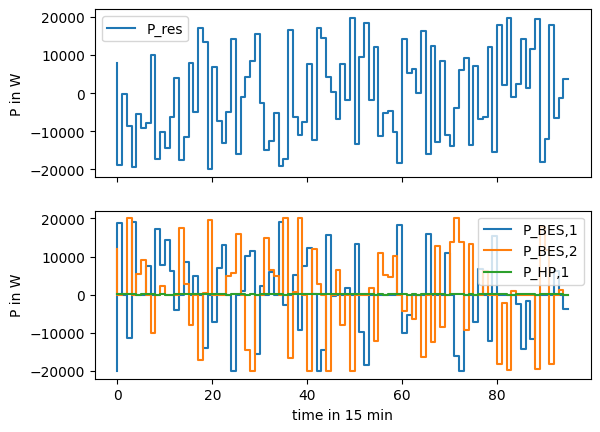

In [5]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)


axs[0].plot(P_res, label='P_res', drawstyle='steps')
axs[0].legend()
axs[0].set_ylabel('P in W')


axs[1].plot(P_bes_1, label='P_BES,1', drawstyle='steps')
axs[1].plot(P_bes_2, label='P_BES,2', drawstyle='steps')
axs[1].plot(P_hp_1, label='P_HP,1', drawstyle='steps')
# axs[1].plot(P_bes_1 + P_bes_2 + P_hp_1, label='P_flex,tot', drawstyle='steps')
axs[1].legend()
axs[1].set_ylabel('P in W')
axs[1].set_xlabel('time in 15 min')

In [89]:


inp = Inputs('Ab', 'bc')
inp.__getattribute__('Ab')

'BAb'

In [37]:
from collections import namedtuple
from types import SimpleNamespace

SyntaxError: invalid syntax (2732843293.py, line 1)

In [70]:
nt = namedtuple('Inputs', ['x', 'y'])

In [ ]:
from typing import NamedTuple

class Inputs(NamedTuple):
    def __init__():
        self.add



In [81]:
a = nt(1, 2)

In [34]:
class Model():
    def __init__(self):
        self.name

    def set_inputs(self, *input_names):
        nt = namedtuple('Inputs', input_names)
        return nt(*[i + '_of_'+ self.name for i in input_names])
    
    def set_inputs(self, *input_names):
        return SimpleNamespace(**{i: i + '_of_'+ self.name for i in input_names})

In [45]:
class Inputs():
    def __init__(self, *inputs):
        for inp in inputs:
            self.__setattr__(inp, inp)

In [49]:
class DynamicAttributesMeta(type):
    def __new__(cls, name, bases, dct):
        dct["_dynamic_attributes"] = set()  # Track dynamic attributes
        return super().__new__(cls, name, bases, dct)


class Inputs(metaclass=DynamicAttributesMeta):
    def __init__(self, *inputs):
        for inp in inputs:
            setattr(self, inp, inp)
            self.__class__._dynamic_attributes.add(inp)

    def __getattr__(self, name):
        if name in self.__class__._dynamic_attributes:
            return name
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")



obj = Inputs("x", "y", "z")


In [71]:
from functools import partial
from collections import namedtuple

inputs = partial(namedtuple, 'Inputs') 

def inputs(*inputs):
    nt = namedtuple('Inputs', (inputs))
    return nt(*inputs)


In [72]:
inp = inputs('A', 'B', 'C')

In [73]:
inp.A

'A'

In [ ]:
__qualname__

In [82]:
from typing import NamedTuple
class Input(NamedTuple):
    pass

In [86]:

class MyModel():
    inputs = namedtuple('Input', ('A', 'B'))

    def __init__(self):
        self.name = 'name'

In [87]:
m = MyModel()


In [88]:
inputs = namedtuple('Input', ('A', 'B'))

In [32]:
import pyomo.environ as pyo
from typing import Protocol, runtime_checkable

@runtime_checkable
class MILPModelProto(Protocol):
    def __init__(self, name:str):
        self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.forcast_inputs   = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.controll_outputs = [] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = [] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods
        self.name             =   'a'

    def pyo_block_rule(self, block:pyo.Block) -> None:
        model = block.model()


class ComponentMock():
    def __init__(self):
        pass
        # self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        # self.forcast_inputs   = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        # self.controll_outputs = [] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        # self.shares           = [] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods
        # self.name             =   'a'
        
    def pyo_block_rule(self, block):
        block.P_el = pyo.Var(block.model().periods)

c = ComponentMock()

isinstance(ComponentMock, MILPModelProto)

True

In [6]:
import pandas as pd

reccords = [
(pd.to_datetime("2020-01-01 12:00"), 1),
(pd.to_datetime("2020-01-01 13:00"), 2),
(pd.to_datetime("2020-01-01 14:00"), 3)
]

pd.DataFrame.from_records(reccords, columns=['index', 'sm'], index='index').squeeze()

index
2020-01-01 12:00:00    1
2020-01-01 13:00:00    2
2020-01-01 14:00:00    3
Name: sm, dtype: int64